In [68]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'inras/code'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/inras/code


In [69]:
# Load data
import numpy as np
# Set device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

X_train = np.load('data.npz')['array']
print(X_train.shape)
Y_train = np.load('mask.npz')['array']
print(Y_train.shape)

Using device: cpu
(853, 256, 208)
(853, 256, 208)


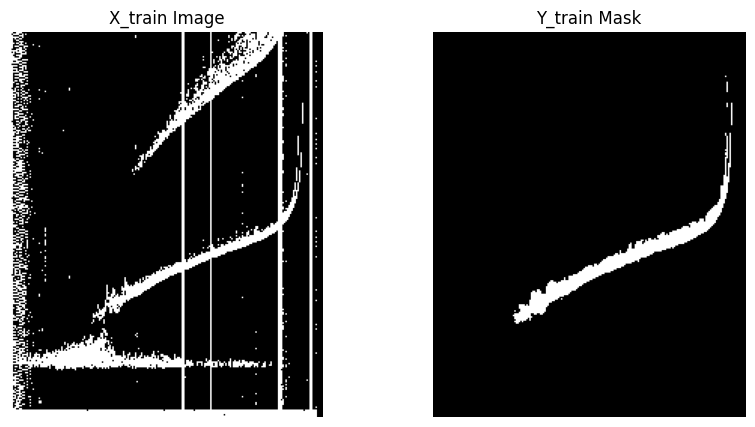

0.0 1.0
0.0 1.0


In [70]:
# Visualize and check the mask coincides with the O mode of the original
import matplotlib.pyplot as plt

# Select an index to visualize the corresponding images from both X_train and Y_train
index = 400  # Change the index to visualize different images

# Plot the images side by side
plt.figure(figsize=(10, 5))

# Display the image from X_train
plt.subplot(1, 2, 1)
plt.imshow(X_train[index], cmap='gray')  # Assuming grayscale images
plt.title('X_train Image')
plt.axis('off')

# Display the image from Y_train
plt.subplot(1, 2, 2)
plt.imshow(Y_train[index], cmap='gray')  # Assuming grayscale masks
plt.title('Y_train Mask')
plt.axis('off')

# Show the plots
plt.show()

# Show some numbers just to make sure the data is either 0 and 1
print(np.min(X_train), np.max(X_train))
print(np.min(Y_train), np.max(Y_train))

# CNN Model

In [71]:
import torch
import torch.nn as nn
from tqdm import trange, tqdm  # Import tqdm explicitly
import time


import torch
import torch.nn as nn
import torch.nn.functional as F

class IonogramNet(nn.Module):
    def __init__(self):
        super(IonogramNet, self).__init__()
        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2, padding=0)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)

        # Decoder
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')

        # Final step, get the correct dimensions
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding='same')

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)

        # Decoder
        x = self.conv4(x)
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.upsample2(x)
        x = self.conv6(x)
        x = self.upsample3(x)

        # Final step
        x = self.conv7(x)
        return x

def test():
    x = torch.randint(0, 2, (3, 1, 256, 208)).float()
    model = IonogramNet()
    pred = model(x)
    print('----------------------------------------------------------------------------------------')
    print('prediction size = ',pred.shape)
    print('input size      = ',x.shape)
    print('Some statistics about the output')
    print(f'Min: {pred.min()}, Max: {pred.max()}, Mean: {pred.mean()}, Std: {pred.std()}')
    sum = torch.sum(pred>0)
    print(sum)
    print('----------------------------------------------------------------------------------------')
    assert pred.shape == x.shape

test()


----------------------------------------------------------------------------------------
prediction size =  torch.Size([3, 1, 256, 208])
input size      =  torch.Size([3, 1, 256, 208])
Some statistics about the output
Min: -0.08999458700418472, Max: -0.05400336533784866, Mean: -0.07280000299215317, Std: 0.0018771692411974072
tensor(0)
----------------------------------------------------------------------------------------


In [72]:
# Pass data to DEVICE

X_train = torch.from_numpy(X_train).float().to(device)
Y_train = torch.from_numpy(Y_train).float().to(device)

# Create the model
LEARNING_RATE = 1e-3
BS = 32
NUM_EPOCHS = 1500

model = IonogramNet().to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Print model summary
print(model)

IonogramNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (upsample1): Upsample(scale_factor=2.0, mode='nearest')
  (conv5): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (upsample2): Upsample(scale_factor=2.0, mode='nearest')
  (conv6): Sequential(
    (0): Conv2d(8,

# Training

In [73]:
losses = []
accuracy = []

for i in (t := trange(NUM_EPOCHS)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].unsqueeze(1)
    Y = Y_train[samp].unsqueeze(1)

    # Forward pass
    pred = model(X)
    loss = loss_function(pred, Y)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    t.set_description(f"Loss: {loss.item():.2f}")


Loss: 0.08: 100%|██████████| 1500/1500 [53:55<00:00,  2.16s/it]


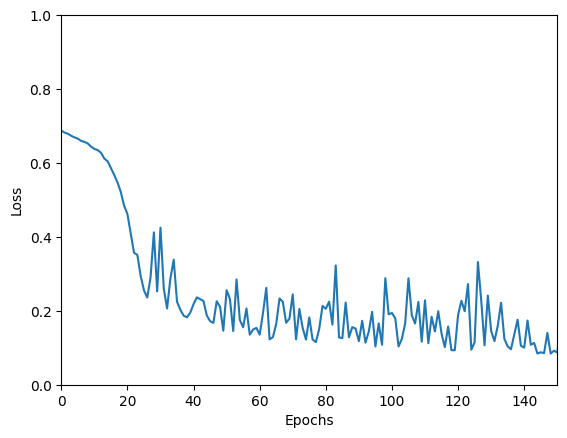

In [82]:
plt.ylim(0,1)
plt.xlim(0,150)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses)

In [76]:
print(X_train.shape)

torch.Size([853, 256, 208])


torch.Size([1, 1, 256, 208])


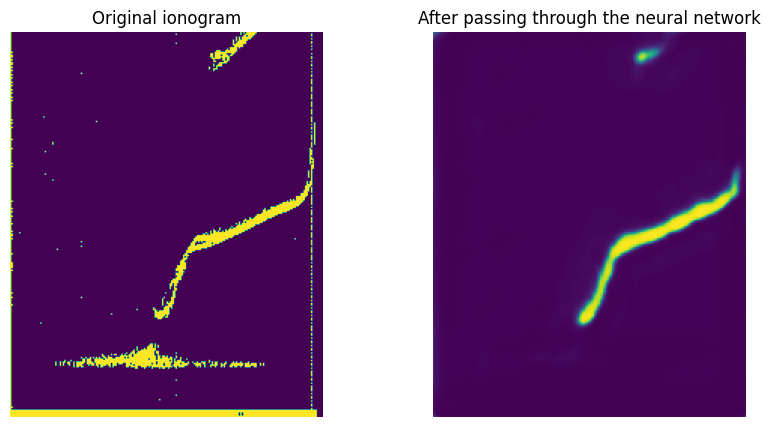

In [87]:
def check_acc():
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        index = 30
        # see first output of the model for the first image from training data
        first_image = torch.sigmoid(model(X_train[index].unsqueeze(0).unsqueeze(0)))
        #first_image = (first_image[0][0] > 0.5).float()
        print(first_image.shape)
        plt.figure(figsize=(10, 5))
        #plt.imshow(first_image[0][0])
        # Display the image from X_train
        plt.subplot(1, 2, 1)
        plt.imshow(X_train[index])  # Assuming grayscale images
        plt.title('Original ionogram')
        plt.axis('off')

        # Display the image from Y_train
        plt.subplot(1, 2, 2)
        plt.imshow(first_image[0][0])  # Assuming grayscale masks
        plt.title('After passing through the neural network')
        plt.axis('off')

        # Show the plots
        plt.show()
check_acc()

In [85]:
# Save the model's state_dict
torch.save(model.state_dict(), 'model_parameters.pth')